# Tutorial to create a logo #

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.insert(0, os.path.abspath('..'))

from Bio import SeqIO
from evoaug_tf import evoaug, augment
from src.deepExplain_tool import getDeepExplainerBackground, deepExplain, plotResults
from src.diff_expression_model import load_model, get_siamese_model
import numpy as np
import importlib
import pickle


2024-07-03 14:14:39.838676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 14:14:40.035278: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 14:14:41.298575: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/shared/apps/x86_64/dependencies_rl9
2024-07-03 14:14:41.298642: W tensorflow/

Retrieve the siamese model based on the weight of Helder

In [2]:

model_path = "./data/model_single.json"
weights_path = "./data/weights_single.h5"

augment_list = [
	augment.RandomRC(rc_prob=0.5),
	augment.RandomInsertionBatch(insert_min=0, insert_max=20),
	augment.RandomDeletion(delete_min=0, delete_max=30),
	augment.RandomTranslocationBatch(shift_min=0, shift_max=20),
	augment.RandomMutation(mutate_frac=0.05),
	augment.RandomNoise()
]

model = load_model(model_path, weights_path)
siamese_model = get_siamese_model(model)



Loaded model from disk


2024-07-03 14:14:46.540179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 14:14:46.609155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21469 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


Generate a background based on the sequences provided by Helder

In [3]:
bg_path = "./data/background_100samples.pkl"
with open(bg_path, 'rb') as f:
    background_data = pickle.load(f)

# Conver to numpy
np_bg = np.array(background_data)

# Remove axis of dimension 1
np_bg = np.squeeze(np_bg)

# Convert to float 64, to be compatible with deepExplain
np_bg = np.float64(np_bg)

background = getDeepExplainerBackground(background_samples=np_bg, shuffle=False, post_hoc_conjoining=True)

The genes for which we want to create a logo

In [4]:
gene_ids_to_explain_klaas = [
	'AT1G21400::Chr1:7493755-7494375(+)',
	'AT3G52780::Chr3:19563207-19563827(-)',
	'AT1G79700::Chr1:29990993-29991613(-)',
	'AT2G20560::Chr2:8849372-8849650(-)',
	'AT1G79700::Chr1:29993088-29993321(-)']

Retrieve the sequences

In [5]:
sequence_list = []
gene_id_list = []

for chunk in range(1,201):
	fasta_path = f"/group/transreg/heopd/dlpipe/code/Sander/data/intron_620_chunks/introns_slide_pad_620.fasta_c{chunk}"
	fasta_sequences = SeqIO.parse(open(fasta_path),'fasta')
	for fasta in fasta_sequences:
		name, sequence = fasta.id, str(fasta.seq)
		if name in gene_ids_to_explain_klaas:
			gene_id_list.append(name)
			sequence_list.append(sequence)

One hot encode the sequences and creat ethe reverse compliment

In [6]:
ohe_list = []
ohe_rc_list = []
for sequence in sequence_list:
	ohe_seq = []
	ohe_rc_seq = []
	for i in sequence:
		if i == 'A':
			ohe_seq.append([1., 0., 0., 0.])
			ohe_rc_seq.append([0., 0., 0., 1.])
		elif i == 'C':
			ohe_seq.append([0., 1., 0., 0.])
			ohe_rc_seq.append([0., 0., 1., 0.])
		elif i == 'G':
			ohe_seq.append([0., 0., 1., 0.])
			ohe_rc_seq.append([0., 1., 0., 0.])
		elif i == 'T':
			ohe_seq.append([0., 0., 0., 1.])
			ohe_rc_seq.append([1., 0., 0., 0.])
		else:
			ohe_seq.append([0., 0., 0., 0.])
			ohe_rc_seq.append([0., 0., 0., 0.])
	ohe_list.append(ohe_seq)
	ohe_rc_list.append(list(reversed(ohe_rc_seq)))
ohe_np = np.array(ohe_list)
ohe_rc_np = np.array(ohe_rc_list)

np_deepexplain_samples = np.stack((ohe_np, ohe_rc_np))

In [7]:
shap_values = deepExplain(samples=np_deepexplain_samples,
                          loaded_model=siamese_model, 
                          bg=background, 
                          post_hoc_conjoining=True, 
                          augment_list=augment_list, 
                          pad_background=True, 
                          pad_samples=False,
                          show_evo_aug_padding=True)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
2024-07-03 14:15:22.085258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8302
2024-07-03 14:15:50.257573: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


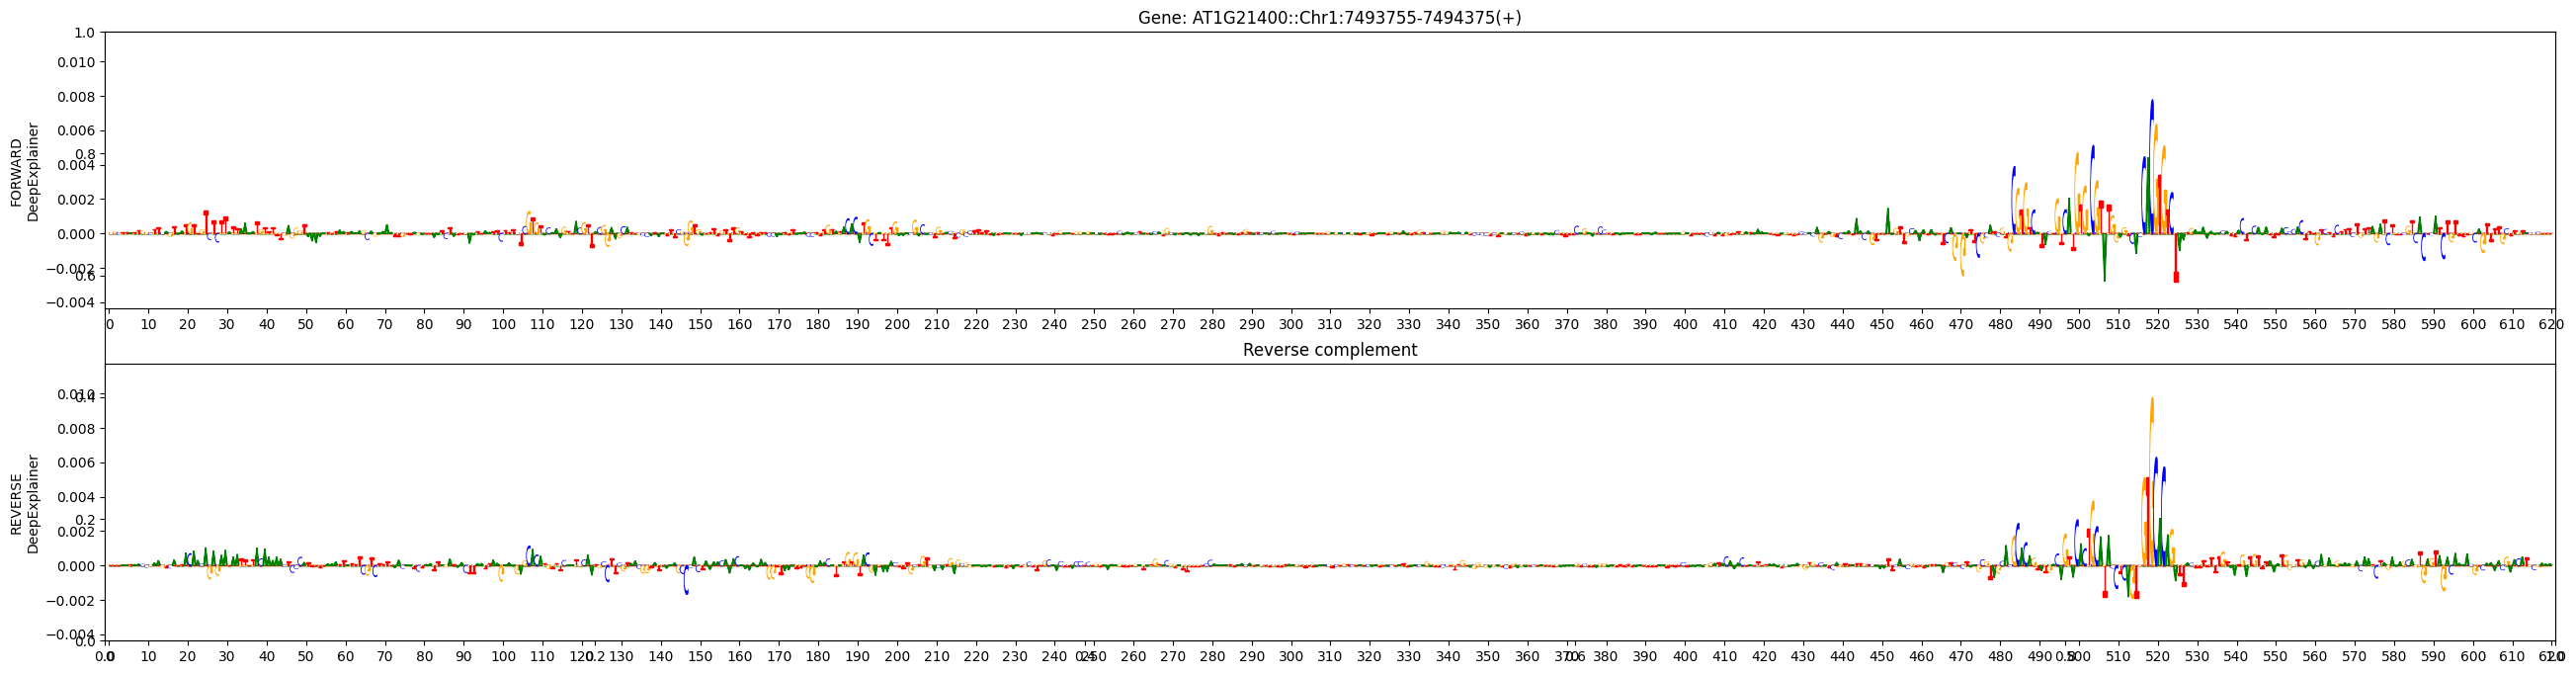

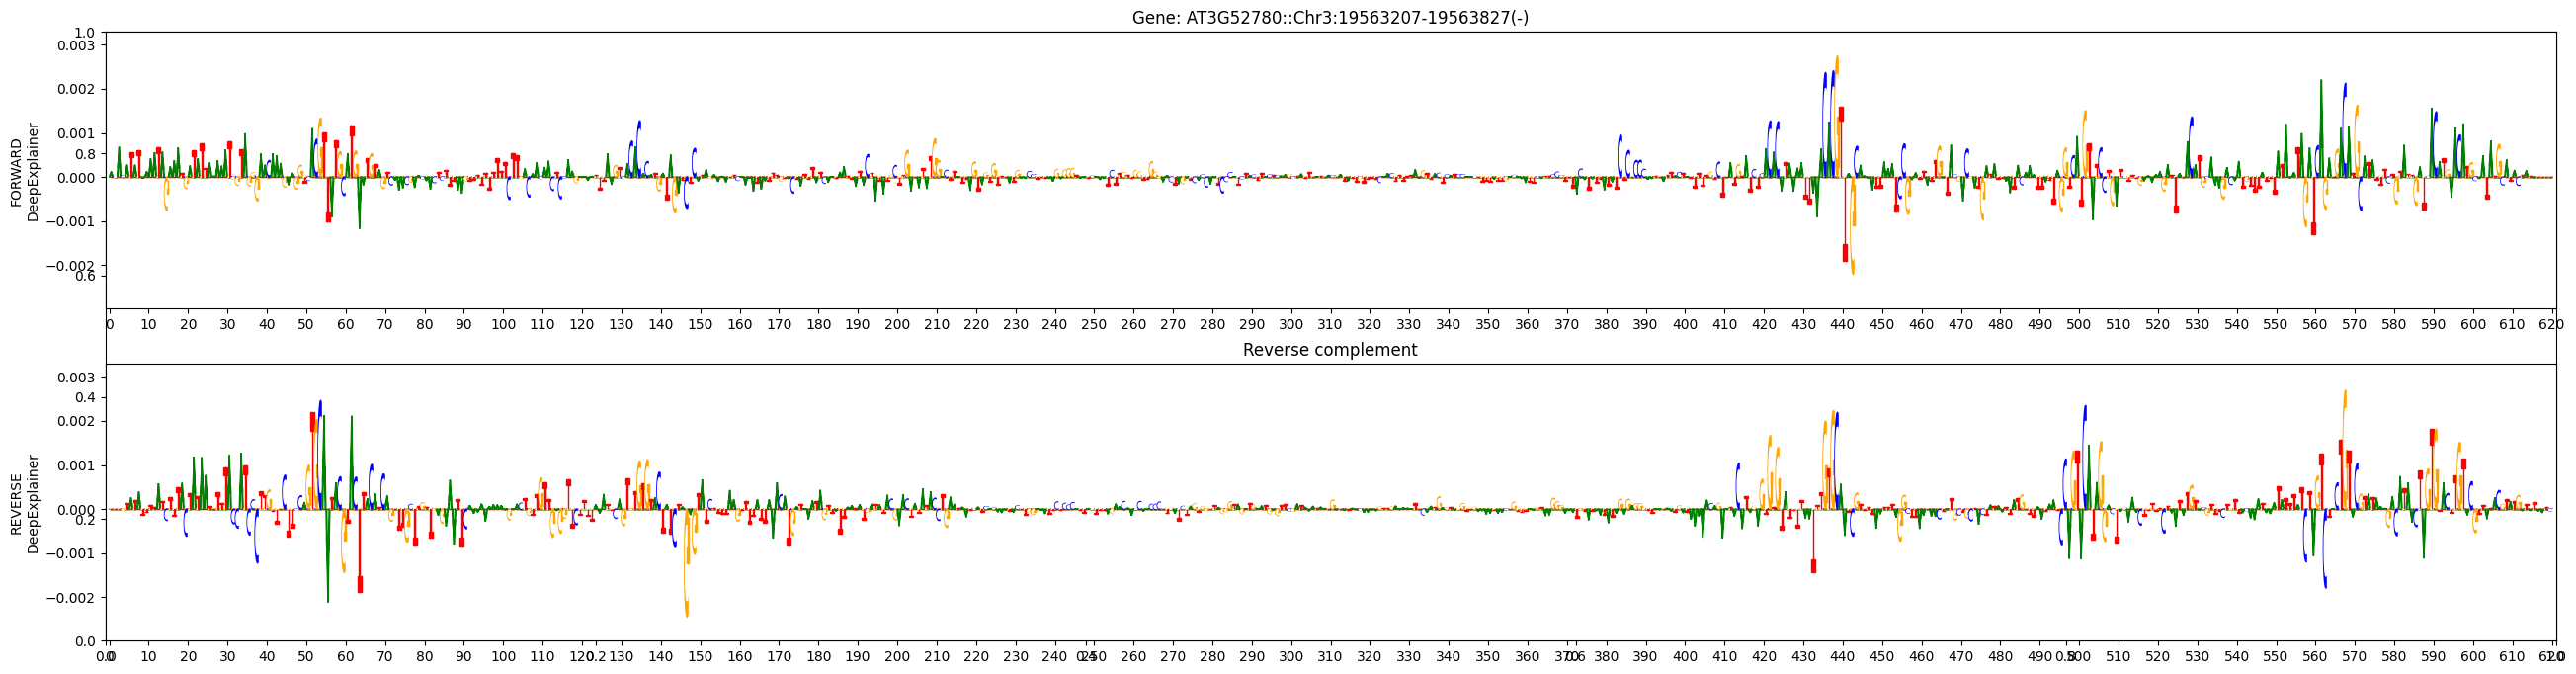

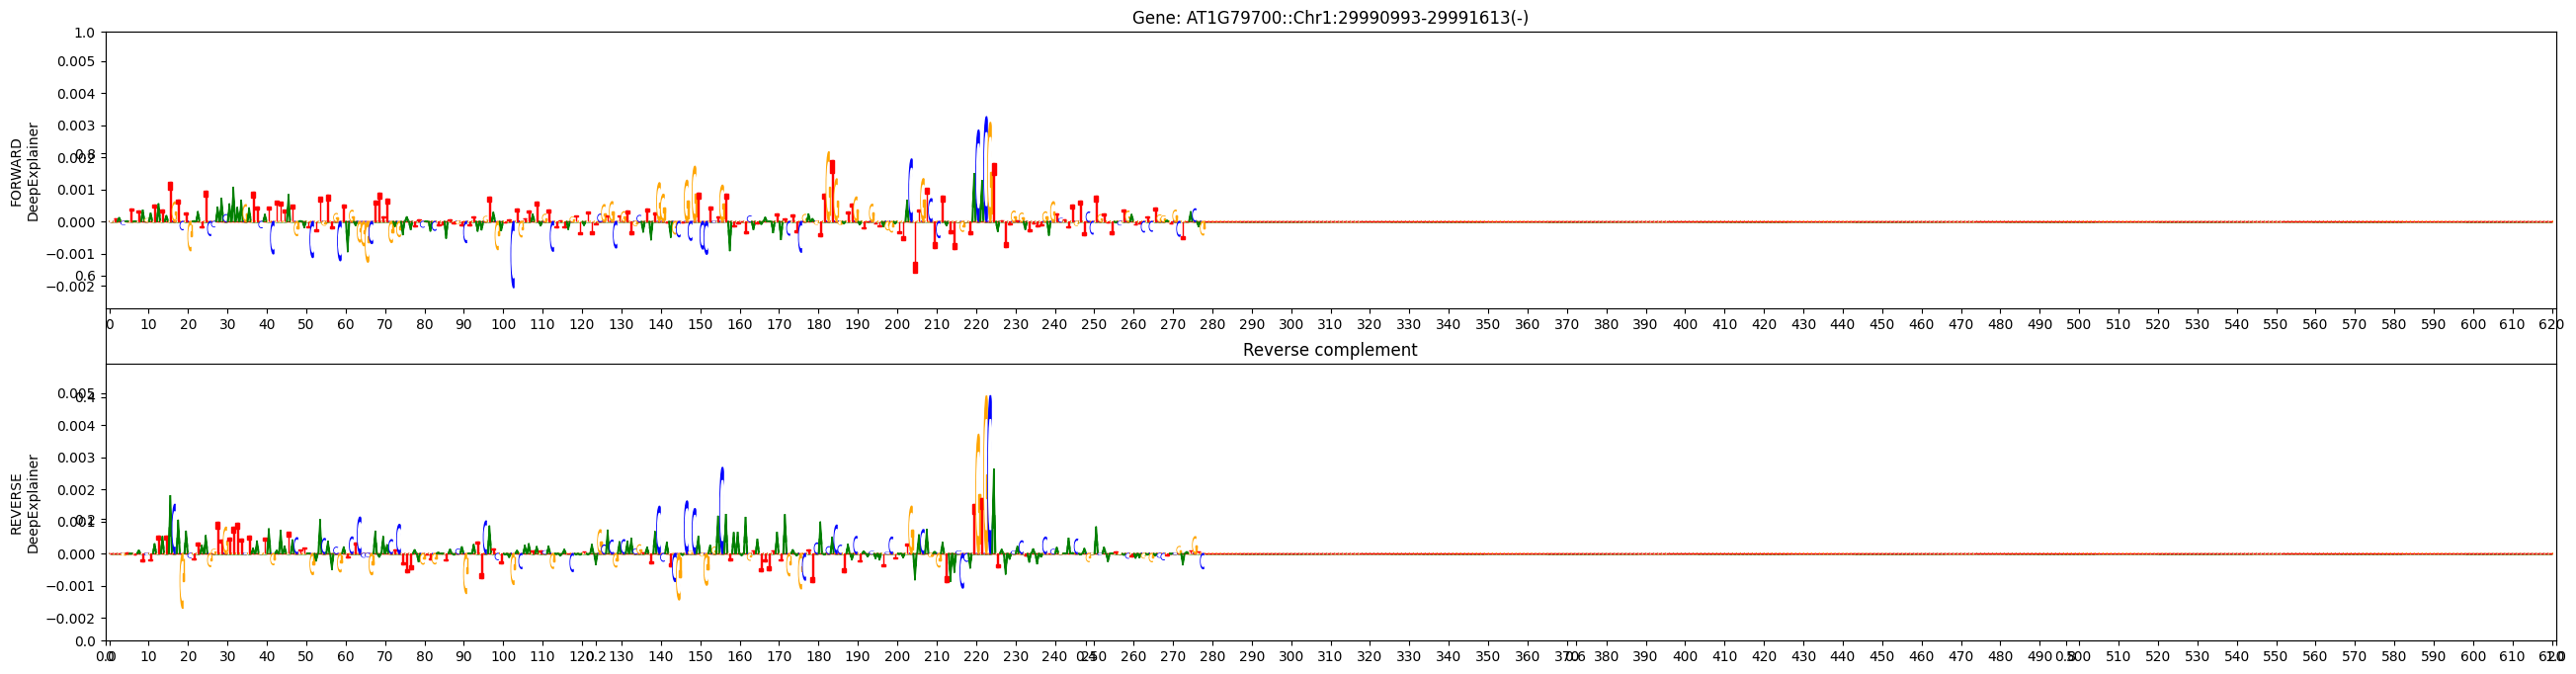

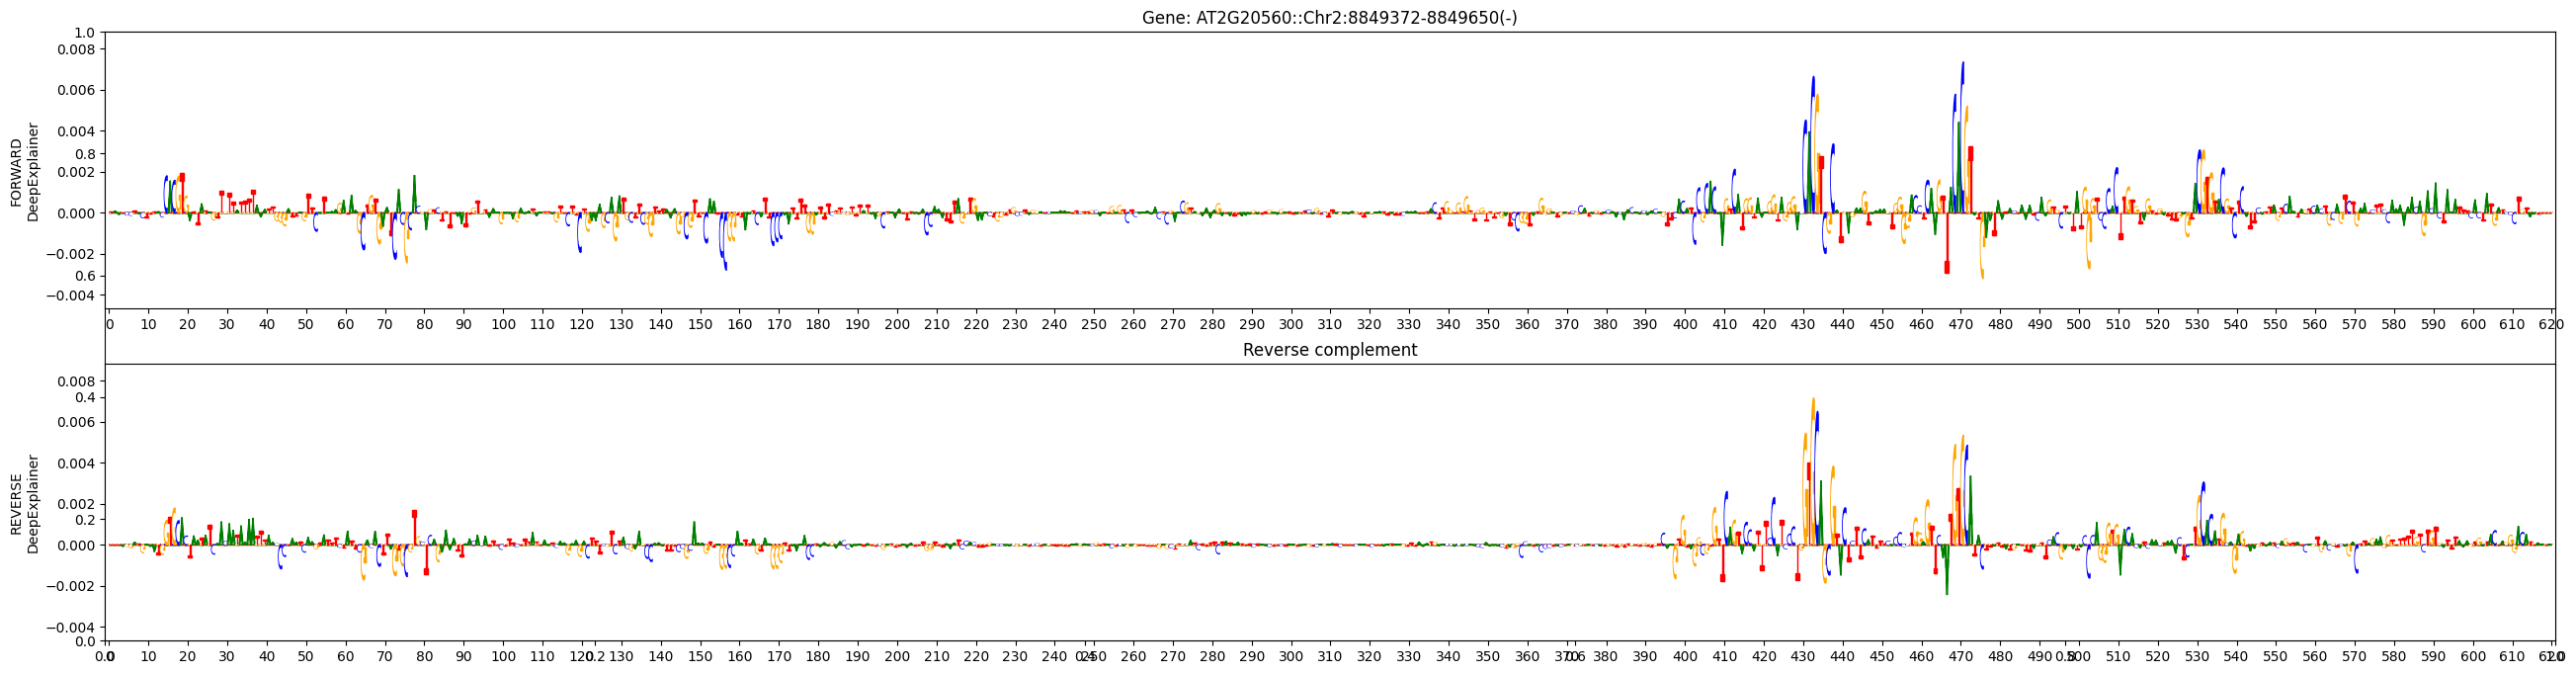

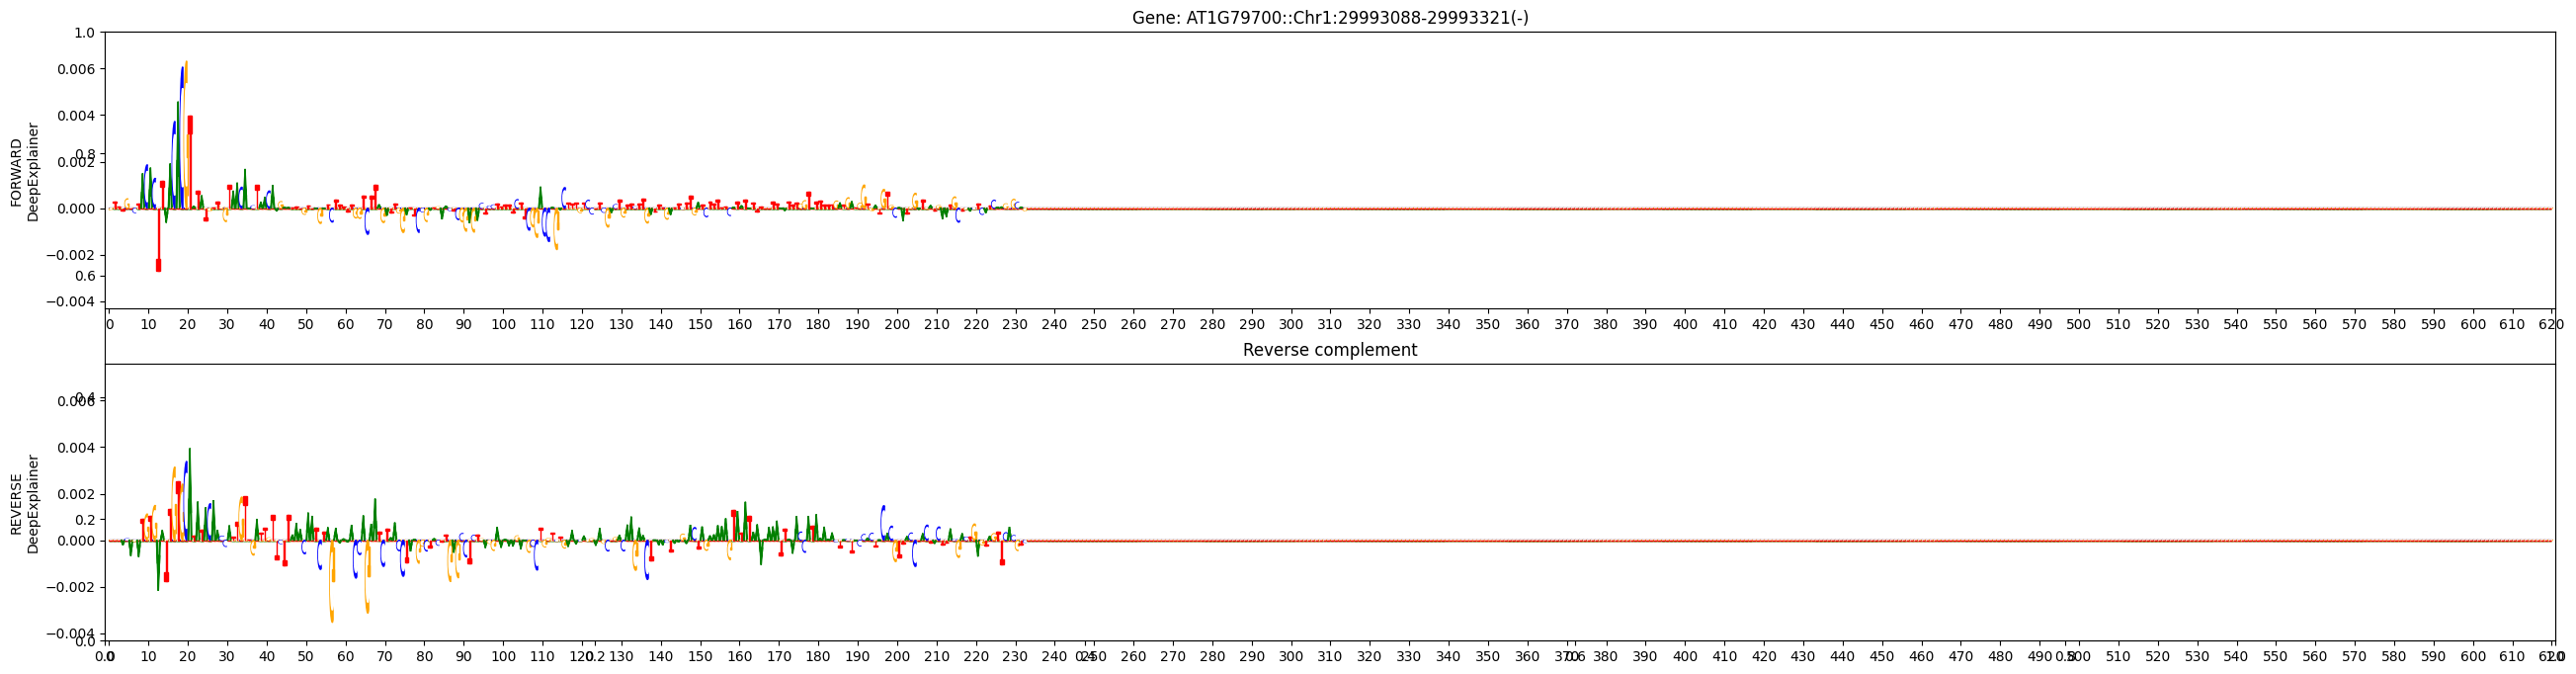

In [8]:
plotResults(shap_values=shap_values, 
            samples=np_deepexplain_samples, 
            post_hoc_conjoining=True, 
            gene_ids=gene_ids_to_explain_klaas,
            in_silico_mut=False,
            model=siamese_model
)